In [12]:
#INSTALISASI LIBRARY
!pip install sastrawi
!pip install tensorflow
!pip install scikit-learn
!pip install pandas nltk wordcloud requests matplotlib seaborn
!pip install lightgbm xgboost catboost
!pip install dask[dataframe]

In [2]:
#Impor LIBRARY
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import requests
import json
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import time
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
#DATASET
import pandas as pd

df = pd.read_csv('/content/Ulasan Snapchat 2000 Data.csv', encoding='utf-8', quotechar='"', escapechar='\\')
df.head()  # Menampilkan 5 baris pertama


,ulasan,label
0,"Baru coba pakai snapchat, kirain aplikasi ini ...",5
1,"dowlond nya capet banget tapi minn ,pas mengin...",4
2,gak bisa di download pas pencet tulisan simpan...,4
3,"apl nya baguss, cuma filter nya banyakin lagi ...",4
4,kualitas video story dan lainya jelek.perbaiki...,1


In [13]:
#DATA CLEANING
clean_df = df.dropna()

In [14]:
clean_df = clean_df.drop_duplicates()


In [15]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ulasan  1999 non-null   object
 1   label   1999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [16]:
clean_df.head()


,ulasan,label
0,"Baru coba pakai snapchat, kirain aplikasi ini ...",5
1,"dowlond nya capet banget tapi minn ,pas mengin...",4
2,gak bisa di download pas pencet tulisan simpan...,4
3,"apl nya baguss, cuma filter nya banyakin lagi ...",4
4,kualitas video story dan lainya jelek.perbaiki...,1


In [19]:
#Pra-pemrosesan Teks (Text Preprocessing)
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word.lower() not in ["mobile", "bni", "wondr", "bni mobile"]])
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [22]:
#Mengambil file dari internet (GitHub), lalu menjadikannya kamus kata gaul → kata baku yang bisa dipakai dalam fungsi fix_slangwords(text)
url = 'https://raw.githubusercontent.com/Nicholas1B/ProjectUAS/refs/heads/main/slangword.json'

response = requests.get(url)

if response.status_code == 200:
    try:
        slangwords = json.loads(response.text)
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code)

In [29]:
clean_df['text_clean'] = clean_df['ulasan'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)


In [30]:
clean_df.head()

,ulasan,label,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Baru coba pakai snapchat, kirain aplikasi ini ...",5,Baru coba pakai snapchat kirain aplikasi ini b...,baru coba pakai snapchat kirain aplikasi ini b...,baru coba pakai snapchat kirain aplikasi ini b...,"[baru, coba, pakai, snapchat, kirain, aplikasi...","[coba, pakai, snapchat, kirain, aplikasi, edit...",coba pakai snapchat kirain aplikasi edit foto ...
1,"dowlond nya capet banget tapi minn ,pas mengin...",4,dowlond nya capet banget tapi minn pas mengins...,dowlond nya capet banget tapi minn pas mengins...,dowlond nya capet banget tapi minn pas mengins...,"[dowlond, nya, capet, banget, tapi, minn, pas,...","[dowlond, capet, banget, minn, pas, menginstal...",dowlond capet banget minn pas menginstal bange...
2,gak bisa di download pas pencet tulisan simpan...,4,gak bisa di download pas pencet tulisan simpan...,gak bisa di download pas pencet tulisan simpan...,tidak bisa di download pas pencet tulisan simp...,"[tidak, bisa, di, download, pas, pencet, tulis...","[download, pas, pencet, tulisan, simpan, muter...",download pas pencet tulisan simpan muter² doan...
3,"apl nya baguss, cuma filter nya banyakin lagi ...",4,apl nya baguss cuma filter nya banyakin lagi y...,apl nya baguss cuma filter nya banyakin lagi y...,apl nya baguss cuma filter nya banyakin lagi y...,"[apl, nya, baguss, cuma, filter, nya, banyakin...","[apl, baguss, filter, banyakin, foto, kebanyak...",apl baguss filter banyakin foto kebanyakan fil...
4,kualitas video story dan lainya jelek.perbaiki...,1,kualitas video story dan lainya jelekperbaiki ...,kualitas video story dan lainya jelekperbaiki ...,kualitas video story dan lainya jelekperbaiki ...,"[kualitas, video, story, dan, lainya, jelekper...","[kualitas, video, story, lainya, jelekperbaiki...",kualitas video story lainya jelekperbaiki keny...


In [32]:
#Pelabelan dan Ekstraksi Fitur
#mengambil dan memuat kamus leksikon sentimen positif dan negatif dari file teks di URL, lalu mengubahnya menjadi dictionary Python berisi pasangan kata dan skor sentimennya.
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            parts = line.split(',')
            word = ','.join(parts[:-1])
            score = parts[-1]
            lexicon[word.strip()] = int(score.strip())
    else:
        print(f"Failed to fetch lexicon data from {url}")

    return lexicon

positive_lexicon_url = 'https://raw.githubusercontent.com/Nicholas1B/ProjectUAS/refs/heads/main/LeksikonPositif.txt'
negative_lexicon_url = 'https://raw.githubusercontent.com/Nicholas1B/ProjectUAS/refs/heads/main/LeksikonNegatif.txt'

# Memuat leksikon positif dan negatif dari URL yang diberikan
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)

In [33]:
#menghitung skor sentimen dan menentukan apakah teks bersentimen positif, negatif, atau netral berdasarkan kamus leksikon kata.
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity = ''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [34]:
#menambahkan hasil analisis sentimen ke DataFrame dan menampilkan jumlah masing-masing jenis sentimen (positif, negatif, netral) dari ulasan yang telah dibersihkan.
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)


results = list(zip(*results))

clean_df['polarity_score'] = results[0]

clean_df['polarity'] = results[1]

print(clean_df['polarity'].value_counts())

polarity
negative    1267
positive     598
neutral      134
Name: count, dtype: int64


In [35]:
#menyiapkan data teks ulasan (X) dan label sentimen (y) hasil analisis leksikon, sebagai input dan target dalam proses pelatihan model klasifikasi sentimen berbasis machine learning.
X = clean_df['text_akhir']
y = clean_df['polarity']

In [36]:
#Ekstraksi Fitur
#ekstraksi fitur teks menggunakan TF-IDF (Term Frequency–Inverse Document Frequency) untuk mengubah data teks ulasan (X) menjadi matriks numerik (X_tfidf) yang bisa digunakan sebagai input ke model machine learning.
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

In [38]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,akun,aneh,apknya,apl,aplikasi,aplikasinya,app,assalamualaikum,ayo,bagus,...,ulang,ulasan,unduh,update,video,vidio,wassalamualaikum,wifi,yh,zenly
0,0.0,0.0,0.0,0.000000,0.109734,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.256494,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.083323,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.744156,0.000000,0.0,0.0,0.0,0.0,0.072698,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.625931,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
1995,0.0,0.0,0.0,0.000000,0.196890,0.0,0.0,0.0,0.0,0.066396,...,0.0,0.0,0.0,0.69055,0.000000,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.208096,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.000000,0.273896,0.0,0.0,0.0,0.0,0.277092,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0


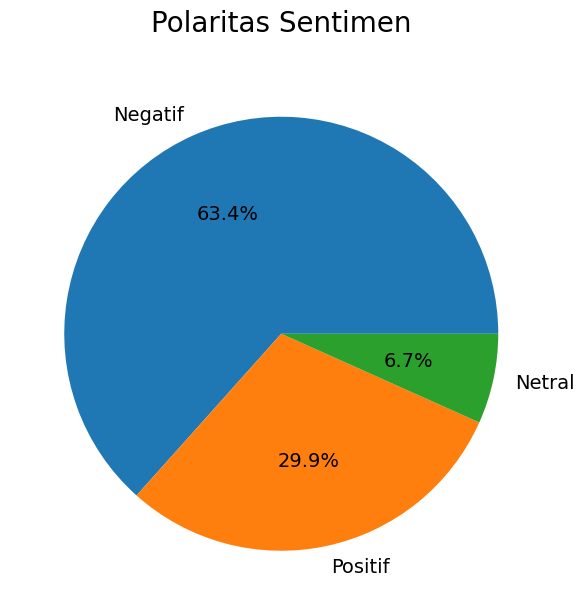

In [39]:
#Visualisasi Data Menampilkan Persentase Polaritas
fig, ax = plt.subplots(figsize=(7, 8))
sizes = [count for count in clean_df['polarity'].value_counts()]
#labels = list(clean_df['polarity'].value_counts().index)  # Mengambil nama kategori polaritas sentimen
labels = ['Negatif', 'Positif', 'Netral']
explode = (0, 0, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polaritas Sentimen', fontsize=20, pad=22)
plt.show()

In [40]:
#Word Cloud atau visualisasi teks yang menampilkan kata-kata berdasarkan frekuensinya, di mana kata yang paling sering muncul ditampilkan dengan ukuran lebih besar untuk memudahkan pemahaman isi teks secara cepat dan menarik.
#Positive Review
positive_review = clean_df[clean_df['polarity'] == 'positive']
positive_review = positive_review[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [42]:
#Negative review
negative_review = clean_df[clean_df['polarity'] == 'negative']
negative_review = negative_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

In [43]:
#neutral review
neutral_review = clean_df[clean_df['polarity'] == 'neutral']
neutral_review = neutral_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False)
neutral_review = neutral_review.reset_index(drop=True)
neutral_review.index += 1

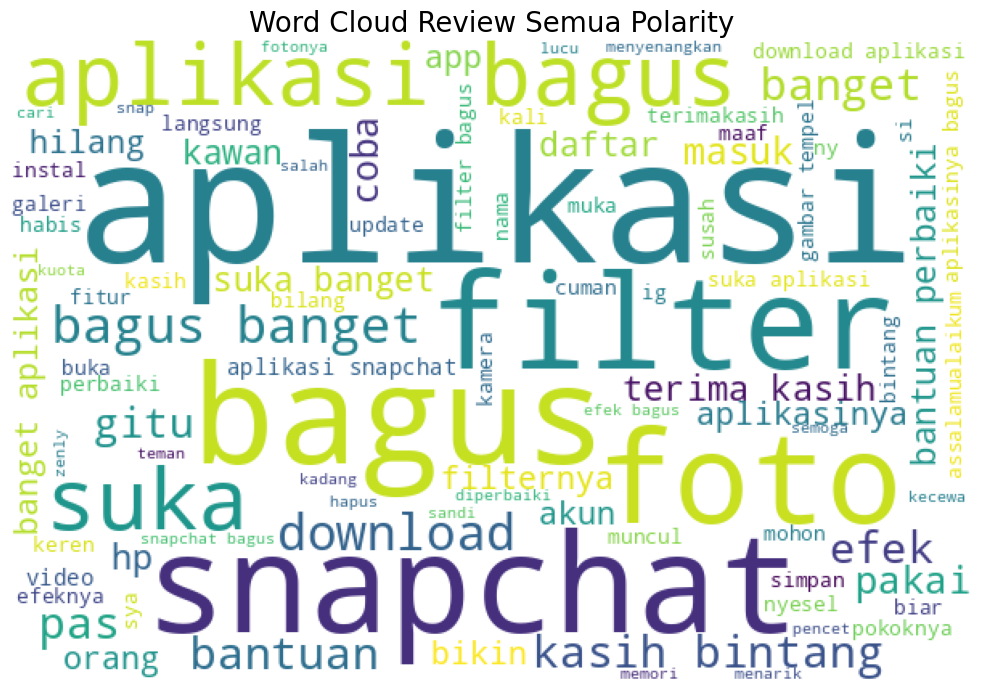

In [44]:
#menggabungkan semua kata ulasan yang telah difilter, lalu menampilkan Word Cloud yang merepresentasikan kata-kata yang paling sering muncul dalam seluruh review.
list_words = ''
for tweet in clean_df['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Semua Polarity', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

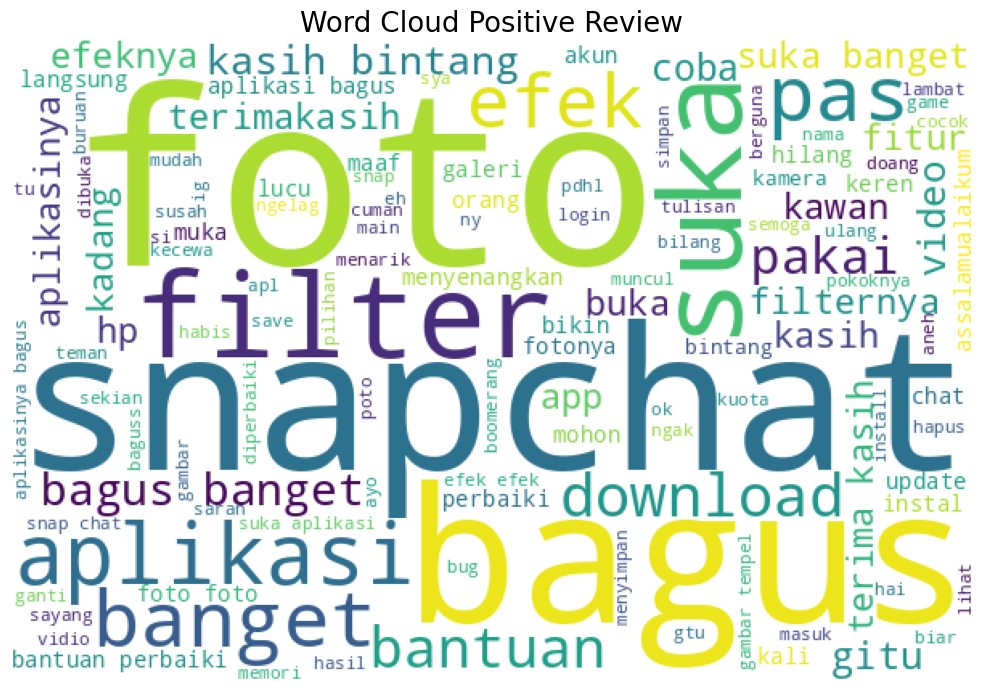

In [45]:
#Filter Kata Hanya Positif saja
list_words = ''
for review in positive_review['text_stopword']:
    for word in review:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Positive Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

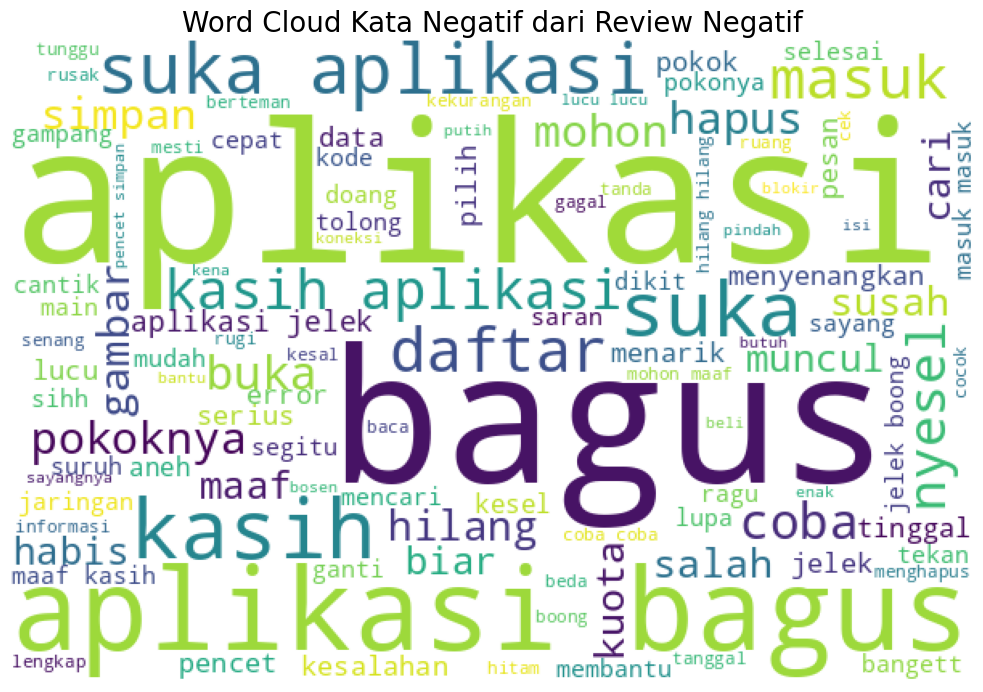

In [47]:
# Filter kata hanya bagian Negatif dan hanya ambil kata yang ada di leksikon negatif
list_words = ''
for review in negative_review['text_stopword']:
    for word in review:
        if word in lexicon_negative:  # hanya kata negatif
            list_words += ' ' + word

# Buat Word Cloud dari kata-kata negatif saja
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Tampilkan Word Cloud
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Kata Negatif dari Review Negatif', fontsize=20)
ax.grid(False)
ax.imshow(wordcloud)
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()


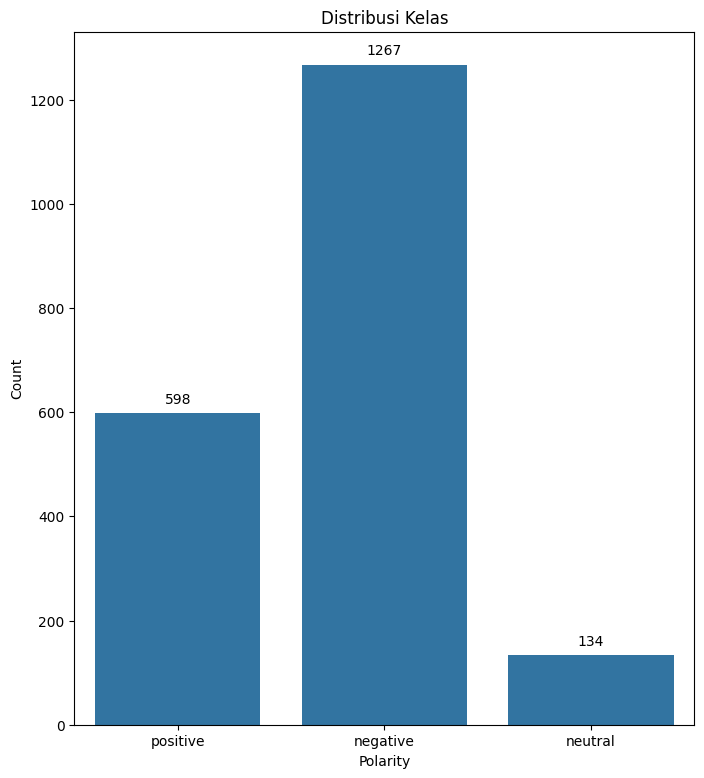

In [48]:
#Distribusi Kelas memvisualisasikan distribusi jumlah data pada tiap label sentimen dalam dataset, sehingga memudahkan analisis keseimbangan data antar kelas (apakah seimbang atau tidak).
# Mengatur ukuran gambar plot
plt.figure(figsize=(8, 9))

# Membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)

# Menetapkan judul plot
plt.title('Distribusi Kelas')

# Menetapkan label sumbu x
plt.xlabel('Polarity')

# Menetapkan label sumbu y
plt.ylabel('Count')

# Menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

# Menampilkan plot
plt.show()

In [50]:
#Permodelan
#Data Spliting : memisahkan data menjadi data latih (training) dan data uji (testing) sebelum membangun model machine learning.
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=50)

In [52]:
#LogisticRegresion
#membangun model klasifikasi sentimen menggunakan Logistic Regression, melatih model pada data ulasan yang sudah diproses, lalu mengukur performanya pada data latih dan data uji.
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8305190744215134
Logistic Regression - accuracy_test: 0.795


In [53]:
#XGBoost
#ode ini membangun dan mengevaluasi model XGBoost untuk klasifikasi sentimen ulasan, dengan hasil akurasi dan waktu pelatihan sebagai metrik kinerja.
# Mengonversi sparse matrix ke array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Melatih model XGBoost pada data pelatihan
start_time = time.time()
xgb.fit(X_train_array, y_train_encoded)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgb.predict(X_train_array)
y_pred_test_xgb = xgb.predict(X_test_array)

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi dan waktu eksekusi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)
print('XGBoost - execution_time:', execution_time, 'seconds')

XGBoost - accuracy_train: 0.981863664790494
XGBoost - accuracy_test: 0.7725
XGBoost - execution_time: 8.823852062225342 seconds


In [54]:
#CatBoost
#Kode ini melatih model CatBoost untuk klasifikasi sentimen dari data teks, lalu mengukur akurasi prediksi dan lama pelatihan, menunjukkan seberapa baik model memahami pola sentimen dalam data
from catboost import CatBoostClassifier
import time

# Membuat objek model CatBoost
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Melatih model CatBoost pada data pelatihan
start_time = time.time()
cat_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_cat = cat_model.predict(X_train.toarray())
y_pred_test_cat = cat_model.predict(X_test.toarray())

# Evaluasi akurasi model CatBoost pada data pelatihan
accuracy_train_cat = accuracy_score(y_pred_train_cat, y_train)

# Evaluasi akurasi model CatBoost pada data uji
accuracy_test_cat = accuracy_score(y_pred_test_cat, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('CatBoost - accuracy_train:', accuracy_train_cat)
print('CatBoost - accuracy_test:', accuracy_test_cat)
print('CatBoost - execution_time:', execution_time, 'seconds')

CatBoost - accuracy_train: 0.8868042526579112
CatBoost - accuracy_test: 0.7625
CatBoost - execution_time: 3.4808952808380127 seconds


In [55]:
#SVM
#Kode ini digunakan untuk melatih dan mengevaluasi model klasifikasi sentimen menggunakan algoritma SVM, lalu mengukur akurasi dan lama waktu pelatihan.
# Membuat objek model SVM
svm = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
start_time = time.time()
svm.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)

# Evaluasi akurasi model SVM pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('SVM - execution_time:', execution_time, 'seconds')

SVM - accuracy_train: 0.8373983739837398
SVM - accuracy_test: 0.7875
SVM - execution_time: 0.1862199306488037 seconds


In [56]:
#Perbandingan Akurasi Model
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Logistic Regression','Support Vector Machine','Extreme Gradient Boosting','Categorical Boosting'],
    'Accuracy Train': [accuracy_train_lr, accuracy_train_svm, accuracy_train_xgb, accuracy_train_cat],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_svm, accuracy_test_xgb, accuracy_test_cat]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model','Accuracy Train', 'Accuracy Test']]

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                       Model  Accuracy Train  Accuracy Test
0        Logistic Regression        0.830519         0.7950
1     Support Vector Machine        0.837398         0.7875
2  Extreme Gradient Boosting        0.981864         0.7725
3       Categorical Boosting        0.886804         0.7625


In [57]:
#Kesimpulan
# Simpan model SVM yang sudah dilatih ke dalam file .pkl agar bisa dimuat kembali di masa depan tanpa perlu retraining.
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

In [58]:
# Simpan TfidfVectorizer
#Kode ini menyimpan TfidfVectorizer ke dalam file .pkl agar bisa digunakan kembali untuk memproses teks baru sebelum prediksi, menjaga konsistensi fitur dengan saat model dilatih.
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [59]:
#Kode ini menghasilkan file requirements.txt yang mencatat semua package dan versinya, agar proyek dapat dijalankan kembali dengan environment yang sama di tempat lain.
!pip freeze > requirements.txt